In [118]:
import numpy as np
import pickle
import os
import xml.etree.ElementTree as ET
import heapq
import utils
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline

In [107]:
!python test_frcnn_iou.py -p TestData/images --input_weight_path 2v100model_frcnn-epoch1090.hdf5

Using TensorFlow backend.
{0: 'unripe_strawberry', 1: 'ripe_strawberry', 2: 'bg'}
W0806 05:39:25.834287 140111219914496 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:71: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 05:39:25.849231 140111219914496 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:514: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 05:39:25.854068 140111219914496 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4076: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 05:39:25.886415 140111219914496 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3900: The name tf.nn.max_pool is deprecated. Please use 

In [108]:
with open('test_pred_boxes.pickle', 'rb') as f:
    pred_boxes = pickle.load(f)
with open('test_times.pickle', 'rb') as f:
    times = pickle.load(f)

In [4]:
PATH = 'TestData/annotations'
actual = {}
for f in os.listdir(PATH):
    if f[-4:] != '.xml':
        continue
    actual[f[:-4]] = []
    for tag in ET.parse(PATH + '/' + f).getroot().findall('object'):
        # (x1, y1, x2, y2, label, prob)
        actual[f[:-4]].append(tuple(
            [int(v.text) for v in tag.find('bndbox')] + [tag.find('name').text]
        ))

In [5]:
def get_iou(box1, box2, epsilon):
    '''
    Calculates intersection over union given two boxes of the form
    [x1, y1, x2, y2]. epsilon prevents divide by zero.
    '''
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    union = (box1[2] - box1[0])*(box1[3] - box1[1]) + \
        (box2[2] - box2[0])*(box2[3] - box2[1]) - intersection
    
    return intersection / (union + epsilon)

In [6]:
# Unit tests. Because the inner SWE thinks I should.
for box1, box2 in [
    [[0,0,1,1], [0,0,.5,.5]], # 0.25
    [[0,0,.5,.5], [0,0,1,1]], # 0.25
    [[0,0,1,1], [1,1,2,2]], # 0.0
    [[0,0,1,1],[0,0,1,1]] # 1.0
]:
    print(get_iou(box1, box2, 1e-16))

0.25
0.25
0.0
1.0


In [109]:
class Result:
    def __init__(self, img_name, actual_box, actual_cls, pred_box, pred_cls, iou, prob):
        self.img_name = img_name
        self.actual_box = actual_box
        self.actual_cls = actual_cls
        self.pred_box = pred_box
        self.pred_cls = pred_cls
        self.iou = iou
        self.prob = prob
    def __repr__(self):
        return 'Result({})'.format(vars(self))

In [8]:
class ImageResult:
    def __init__(
        self,
        img_name,
        img_shape=None,
        test_time=0,
        actual_boxes=0,
        pred_boxes=0,
        missing=0,
        added=0,
        total=0):
        
        self.img_name = img_name
        self.img_shape = img_shape
        self.test_time = test_time
        self.actual_boxes = actual_boxes
        self.pred_boxes = pred_boxes
        # missing is not necessarily actual - pred because some predicted are wrong
        self.missing = missing
        self.added = added
        self.total = total
    def __repr__(self):
        return 'ImageResult({})'.format(vars(self))

In [22]:
# For true positive, false positive, true negative, false negative
class LabelResult:
    def __init__(self, label, tp=0, fp=0, tn=0, fn=0):
        self.label = label
        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

## Algorithm for Scoring Results
1. Calculate IOU for each pair of boxes in the actual set and predicted set.
2. Insert the tuple of `(IOU, box1, box2)` into a max heap
3. Continuously pop off tuples until either the heap is empty (probably never) or the top score is below the threshold.
5. ????
6. Profit

In [111]:
results = []

# threshold for two boxes to be considered the "same"
iou_threshold = 0.5
for f in actual:
    s1, s2 = set(actual[f]), set(pred_boxes[f])
    
    # Max heap so first element is negative
    heap = [(-get_iou(b1[:4], b2[:4], 1e-16), b1, b2) for b1 in s1 for b2 in s2]
    heapq.heapify(heap)
    
    while heap and heap[0][0] < -iou_threshold:
        iou, b1, b2 = heapq.heappop(heap)
        if b1 in s1 and b2 in s2:
            results.append(Result(f, b1[:4], b1[4], b2[:4], b2[4], -iou, b2[5]))
            s1.remove(b1)
            s2.remove(b2)
        if not s1 or not s2:
            # Early break if we run out
            break
    
    while s1:
        b1 = s1.pop()
        results.append(Result(f, b1[:4], b1[4], None, None, None, None))
    while s2:
        b2 = s2.pop()
        results.append(Result(f, None, None, b2[:4], b2[4], None, None))

## ROC AUC (no penalty for missing box)

In [131]:
y_test = []
probs = []

for r in results:
    if r.actual_cls is None or r.pred_cls is None:
        continue
    if r.actual_cls == 'ripe_strawberry':
        y_test.append(1)
        probs.append(r.prob if r.pred_cls == 'ripe_strawberry' else 1 - r.prob)
    else:
        y_test.append(0)
        probs.append(r.prob if r.pred_cls == 'ripe_strawberry' else 1 - r.prob)

In [132]:
roc_auc_score(y_test, probs)

0.9981078524124881

In [133]:
fpr, tpr, thresholds = roc_curve(y_test, probs)

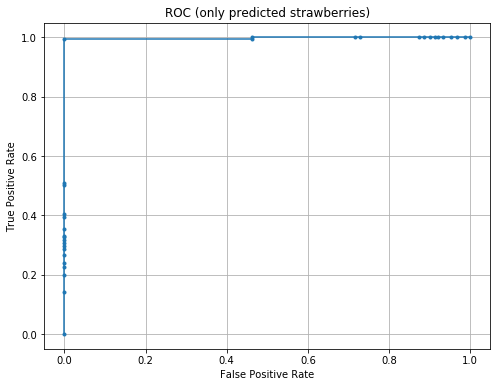

In [134]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.title('ROC (only predicted strawberries)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

## Inference Time

In [11]:
'Average inference time: {} s'.format(np.mean(list(times.values())))

'Average inference time: 0.7346933346528274 s'

In [46]:
print('Mean intersection over union: {}'.format(np.mean([r.iou for r in results if r.iou is not None])))

Mean intersection over union: 0.746629092880757


In [13]:
img_shapes = {}
IMAGE_PATH = 'TestData/images/'
for f in os.listdir(IMAGE_PATH):
    if f.endswith('.jpg'):
        img_shapes[f] = utils.read_image(IMAGE_PATH + f).shape

In [65]:
img_results = {}
for r in results:
    img_name = r.img_name + '.jpg'
    if img_name not in img_results:
        img_results[img_name] = ir = ImageResult(img_name)
    
    ir.img_shape = img_shapes[img_name]
    ir.test_time = times[img_name[:-4]]
    ir.actual_boxes += int(r.actual_box is not None)
    ir.pred_boxes += int(r.pred_box is not None)
    ir.missing += int(r.pred_box is None)
    ir.added += int(r.actual_box is None)
    ir.total += 1
    

In [99]:
t = []
pixels = []
n_actual = []
n_pred = []

for f in times:
    name = f+'.jpg'
    if name not in img_results:
        continue
    t.append(times[f])
    pixels.append(np.prod(img_results[name].img_shape))
    n_actual.append(img_results[name].actual_boxes)
    n_pred.append(img_results[name].pred_boxes)

pixels = np.array(pixels)
n_actual = np.array(n_actual)
n_pred = np.array(n_pred)

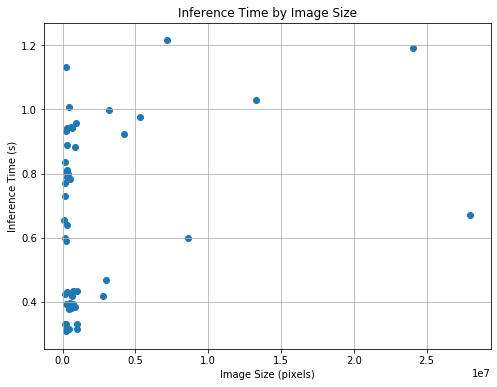

In [100]:
plt.figure(figsize=(8,6))
plt.scatter(pixels/3, t)
plt.title('Inference Time by Image Size')
plt.xlabel('Image Size (pixels)')
plt.ylabel('Inference Time (s)')
plt.grid()

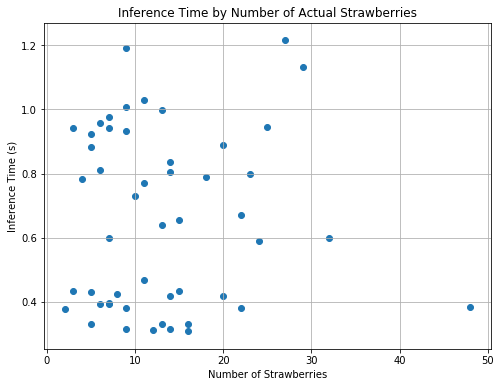

In [104]:
plt.figure(figsize=(8,6))
plt.scatter(n_actual, t)
plt.title('Inference Time by Number of Actual Strawberries')
plt.xlabel('Number of Strawberries')
plt.ylabel('Inference Time (s)')
plt.grid()

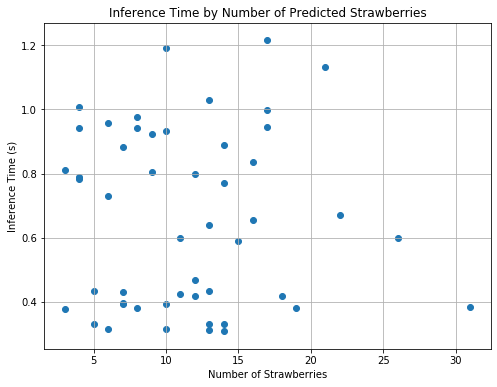

In [105]:
plt.figure(figsize=(8,6))
plt.scatter(n_pred, t)
plt.title('Inference Time by Number of Predicted Strawberries')
plt.xlabel('Number of Strawberries')
plt.ylabel('Inference Time (s)')
plt.grid()

In [48]:
print('Mean number of missing boxes: {}'.format(np.mean([ir.missing for ir in img_results.values()])))
print('Mean number of added boxes: {}'.format(np.mean([ir.added for ir in img_results.values()])))

Mean number of missing boxes: 5.28
Mean number of added boxes: 3.56


In [51]:
print('Worst image in terms of missing boxes')
print(max(img_results.values(), key=lambda ir: ir.missing))
print('Best image in terms of missing boxes')
print(min(img_results.values(), key=lambda ir: ir.missing))

Worst image in terms of missing boxes
ImageResult({'img_name': 'strawimage68.jpg', 'img_shape': (800, 1053, 3), 'test_time': 0.49787425994873047, 'actual_boxes': 48, 'pred_boxes': 31, 'missing': 21, 'added': 4, 'total': 52})
Best image in terms of missing boxes
ImageResult({'img_name': 'strawimage88.jpg', 'img_shape': (345, 512, 3), 'test_time': 0.8420779705047607, 'actual_boxes': 11, 'pred_boxes': 14, 'missing': 0, 'added': 3, 'total': 14})


In [52]:
print('Worst image in terms of added boxes')
print(max(img_results.values(), key=lambda ir: ir.added))
print('Best image in terms of added boxes')
print(min(img_results.values(), key=lambda ir: ir.added))

Worst image in terms of added boxes
ImageResult({'img_name': 'strawimage56.jpg', 'img_shape': (676, 890, 3), 'test_time': 0.8630719184875488, 'actual_boxes': 25, 'pred_boxes': 17, 'missing': 18, 'added': 10, 'total': 35})
Best image in terms of added boxes
ImageResult({'img_name': 'strawimage78.jpg', 'img_shape': (625, 1000, 3), 'test_time': 0.9667212963104248, 'actual_boxes': 7, 'pred_boxes': 4, 'missing': 3, 'added': 0, 'total': 7})


In [16]:
print('Mean number of actual boxes: {}'.format(np.mean([ir.actual_boxes for ir in img_results.values()])))
print('Mean number of predicted boxes: {}'.format(np.mean([ir.pred_boxes for ir in img_results.values()])))

Mean number of actual boxes: 13.2
Mean number of predicted boxes: 11.48


In [31]:
max(ir.actual_boxes for ir in img_results.values())

48

In [53]:
label_results = {
    'ripe_strawberry': LabelResult('ripe_strawberry'),
    'unripe_strawberry': LabelResult('unripe_strawberry')
}

for r in results:
    if r.actual_cls is None:
        continue
#     if r.pred_cls is None:
#         continue
    if r.pred_cls == r.actual_cls:
        for label, lr in label_results.items():
            if label == r.actual_cls:
                lr.tp += 1
            else:
                lr.tn += 1
    else:
        for label, lr in label_results.items():
            if label == r.actual_cls:
                lr.fn += 1
            else:
                lr.fp += 1
    

In [54]:
ripe, unripe = label_results.values()
print('Ripe precision: {}'.format(ripe.tp / (ripe.tp + ripe.fp)))
print('Ripe recall: {}'.format(ripe.tp / (ripe.tp + ripe.fn)))
print('Unripe precision: {}'.format(unripe.tp / (unripe.tp + unripe.fp)))
print('Unripe recall: {}'.format(unripe.tp / (unripe.tp + unripe.fn)))

Ripe precision: 1.0
Ripe recall: 0.9959183673469387
Unripe precision: 0.993421052631579
Unripe recall: 1.0
